In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/stock-prediction-using-sentiment-analysis/json_data_final.csv
/kaggle/input/stock-prediction-using-sentiment-analysis/train_data-1573118738755.json
/kaggle/input/stock-prediction-using-sentiment-analysis/test_data.json
/kaggle/input/stock-prediction-using-sentiment-analysis/train_factors-1573207730757.csv
/kaggle/input/stock-prediction-using-sentiment-analysis/jsonWsenti2.csv
/kaggle/input/stock-prediction-using-sentiment-analysis/test_factors.csv


# Synopsis
The follwing the work flow of the notebook
* Reading and Preproccesing the "train_data.json" file
* EDA,Visualising and drawing insights from "train.json" file
* Reading and Preproccesing the "train_factors.csv" file
* EDA,Visualising and drawing insights from "train_factors.csv" file
* Analysing if adding Sentiment score from "train_data.json" file to "train_factors.csv" will improve the prediciton accuracy

In [2]:
import json
import pandas as pd
from pandas.io.json import json_normalize 
import numpy as np
import re


In [3]:
url1 = '/kaggle/input/stock-prediction-using-sentiment-analysis/train_data-1573118738755.json'
url2 = '/kaggle/input/stock-prediction-using-sentiment-analysis/train_factors-1573207730757.csv'
df = pd.read_json(url1, orient='columns')


In [4]:
df.head()

,records
0,{'stocktwit_tweet': '$AMD going up but hesitat...
1,{'stocktwit_tweet': '@inforlong @MariaGascon D...
2,"{'stocktwit_tweet': '$AVGO WTF?', 'sentiment_s..."
3,{'stocktwit_tweet': '$PH New Insider Filing O...
4,{'stocktwit_tweet': '$FB if it bounces tommorr...


In [5]:
with open(url1) as f: 
    json_data = json.load(f) 

In [6]:
train_json = json_normalize(json_data['records']) 


In [7]:
train_json.head(2)

,stocktwit_tweet,sentiment_score,timestamp,ticker
0,$AMD going up but hesitating however chart is ...,3,2018-09-19 18:38:28+00:00,$AMD
1,@inforlong @MariaGascon Despite\nChina trade w...,3,2018-10-09 03:51:06+00:00,$CAT


In [8]:
#writing the data frame to a csv file for inspection
#train_json.to_csv("json_data.csv")
train_json.to_csv("json_data_final.csv")

In [9]:
#Need to remove all the urls in the tweets
train_json.iloc[15,0]

'$NWL Earnings August 06 BMO. 17-Aug-18 Straddle Implies ±7.1% Move vs 6qtr Absolute Avg 9.0% http://tinyurl.com/ya3kzmvn'

In [10]:
train_json.shape

(1039131, 4)

In [11]:
#Multiple rows with same ticker on a given day, different tweets and different sentiment score
train_json[train_json['ticker'] == '$AMD' ]

,stocktwit_tweet,sentiment_score,timestamp,ticker
0,$AMD going up but hesitating however chart is ...,3,2018-09-19 18:38:28+00:00,$AMD
9,$AMD Pastor the Stooge,2,2018-08-17 13:35:00+00:00,$AMD
16,$AMD buying more,4,2018-09-18 15:45:22+00:00,$AMD
36,$AMD Good luck to everyone that holds.,3,2018-10-24 19:52:13+00:00,$AMD
39,$AMD analysts on Estimize expect 7.61% YoY gro...,1,2018-09-06 12:36:09+00:00,$AMD
...,...,...,...,...
1039121,$AMD INVERTED HAMMER 3rd time is a charm !!! ...,4,2018-07-22 17:05:38+00:00,$AMD
1039123,"$AMD don’t even play, y’all know it’s gapping ...",3,2018-09-14 19:36:39+00:00,$AMD
1039125,$AMD prepare yourselves for launch. Closing 28...,3,2018-09-04 18:01:16+00:00,$AMD
1039127,$AMD 🔥🔥🔥,3,2018-09-04 15:25:59+00:00,$AMD


In [12]:
#Total of 2181 different tickers
print(np.size(train_json['ticker'].unique()))
print((train_json["ticker"].value_counts()).head(2))


2181
$AMD    163675
$MU      82680
Name: ticker, dtype: int64


In [13]:
#approx 4months of historical data is made avaliable

#coverting timestamp data into date format in the Factors.csv file
train_json['timestamp'] = pd.to_datetime(train_json['timestamp'])

#train_json['timestamp'] = train_json['timestamp'].dt.strftime('%d/%m/%y')
print(train_json.head(2))
print(train_json["timestamp"].min())
print(train_json["timestamp"].max())

                                     stocktwit_tweet  sentiment_score  \
0  $AMD going up but hesitating however chart is ...                3   
1  @inforlong @MariaGascon Despite\nChina trade w...                3   

                  timestamp ticker  
0 2018-09-19 18:38:28+00:00   $AMD  
1 2018-10-09 03:51:06+00:00   $CAT  
2018-07-01 00:00:09+00:00
2018-10-31 23:59:57+00:00


## Peprocessing Steps of the Json file
* Convert emojis to text
* Remove the $ticker from the tweet
* Remove the urls in the tweet
* Remove the time and retain only the date in the time stamp
* Retain the emojis, they could be useful
* Remove the numbers from the tweets
* Aggregate all the tweets at a day level into one tweet and run sentiment analysis

In [14]:

import emoji
train_json['stocktwit_tweet']=train_json['stocktwit_tweet'].apply(lambda x: emoji.demojize(x))

In [15]:
train_json.dtypes

stocktwit_tweet                 object
sentiment_score                  int64
timestamp          datetime64[ns, UTC]
ticker                          object
dtype: object

In [16]:
#Converting to lowercase
train_json['stocktwit_tweet'] = [text.strip().lower() for text in train_json['stocktwit_tweet']]
train_json['stocktwit_tweet'][:2]

0    $amd going up but hesitating however chart is ...
1    @inforlong @mariagascon despite\nchina trade w...
Name: stocktwit_tweet, dtype: object

In [17]:
#Handling contractions
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [18]:
def expand_contractions(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text

In [19]:
train_json['stocktwit_tweet'] = [expand_contractions(re.sub('’', "'", text)) for text in train_json['stocktwit_tweet']]
train_json['stocktwit_tweet'][1]

'@inforlong @mariagascon despite\nchina trade war $cat held very well :thumbs_up:'

In [20]:
#Removing ascented characters
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #https://docs.python.org/2/library/unicodedata.html
    return text

train_json['stocktwit_tweet'] = [remove_accented_chars(text) for text in train_json['stocktwit_tweet']]


In [21]:
train_json['stocktwit_tweet'][1]

'@inforlong @mariagascon despite\nchina trade war $cat held very well :thumbs_up:'

In [22]:
import re
#Removing usernames which start with @
train_json['stocktwit_tweet'] = train_json['stocktwit_tweet'].str.replace(r'@\S*\s', '')


In [23]:
#Removing the ticker and numbers which have $ symbol in it
train_json['stocktwit_tweet'] = train_json['stocktwit_tweet'].str.replace('\w*[$]\w*', '')

#(\w*$\w+|\w+$\w*)


In [24]:
train_json.head(2)

,stocktwit_tweet,sentiment_score,timestamp,ticker
0,going up but hesitating however chart is very...,3,2018-09-19 18:38:28+00:00,$AMD
1,despite\nchina trade war held very well :thum...,3,2018-10-09 03:51:06+00:00,$CAT


In [25]:
#Removing all the urls
train_json['stocktwit_tweet'] = train_json['stocktwit_tweet'].str.replace(r"http\S+", '')

In [26]:
#Verifying if the above step worked
train_json.iloc[11,0]

' exp:7/20/2018|maxpain:292.5|highputoi:250.0(788)|highcalloi:360.0(2019) '

In [27]:
#Removing the Scrub words
def scrub_words(text):
    #Replace \xao characters in text
    text = re.sub('\xa0', ' ', text)
    
    #Replace non ascii / not words and digits
    text = re.sub("(\\W|\\d)",' ',text)
    
    #Replace numbers in the words and in the tweet
    text = re.sub("[^a-zA-Z#]", " ",text)
    
    #Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)
    
    #Remove html markup
    text = re.sub("<.*?>", ' ', text)
    
    #Remove extra spaces from the text
    text = re.sub("\s+", ' ', text)
    return text

train_json['stocktwit_tweet'] = [scrub_words(text) for text in train_json['stocktwit_tweet']]


In [28]:
# Dropping rows which are blank
train_json['stocktwit_tweet'].replace('', np.nan, inplace=True)
train_json.dropna(subset=['stocktwit_tweet'], inplace=True)

In [29]:
train_json.dtypes

stocktwit_tweet                 object
sentiment_score                  int64
timestamp          datetime64[ns, UTC]
ticker                          object
dtype: object

In [30]:
#finding and dropping duplicated rows
print(train_json.duplicated().sum())
train_json.drop_duplicates(keep='first',inplace=True)


153


In [31]:
train_json.iloc[11,0]

' exp maxpain highputoi highcalloi '

# Visualization

### This section deals with plotting visual aids to extract inssights from data

In [32]:
import squarify
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
## Visualising no.of tweets per a weekday
train_json['tweeted_day_of_week'] = train_json['timestamp'].dt.weekday_name


In [34]:
import plotly as py
x = 0.
y = 0.
width = 50.
height = 50.
type_list = list(train_json['tweeted_day_of_week'].unique())
values = [len(train_json[train_json['tweeted_day_of_week'] == i]) for i in type_list]

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)

color_brewer = ['#2D3142','#4F5D75','#BFC0C0','#F2D7EE','#EF8354','#839788','#EEE0CB']
shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append( 
        dict(
            type = 'rect', 
            x0 = r['x'], 
            y0 = r['y'], 
            x1 = r['x']+r['dx'], 
            y1 = r['y']+r['dy'],
            line = dict( width = 2 ),
            fillcolor = color_brewer[counter]
        ) 
    )
    annotations.append(
        dict(
            x = r['x']+(r['dx']/2),
            y = r['y']+(r['dy']/2),
            text = "{}-{}".format(type_list[counter], values[counter]),
            showarrow = False
        )
    )
    counter = counter + 1
    if counter >= len(color_brewer):
        counter = 0

# For hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects ], 
    y = [ r['y']+(r['dy']/2) for r in rects ],
    text = [ str(v) for v in values ], 
    mode = 'text',
)
        
layout = dict(
    height=700, 
    width=700,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest',
    font=dict(color="#FFFFFF")
)

# With hovertext
figure1 = dict(data=[trace0], layout=layout)
iplot(figure1, filename='squarify-treemap')


## Observations
* Saturday and Sunday have the least no.of tweets as the stock market is closed on those days
* Tuesday, Wednesday and Thursday have alomost equal no.of tweets, it can be inferred that, that's when most of the trades are done

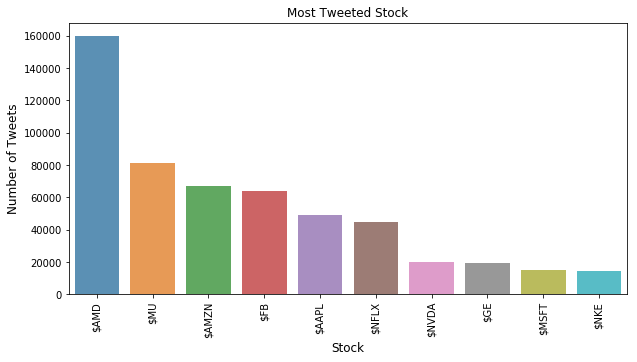

In [35]:
count_  = train_json['ticker'].value_counts()
count_ = count_[:10,]
plt.figure(figsize=(10,5))
sns.barplot(count_.index, count_.values, alpha=0.8)
plt.title('Most Tweeted Stock')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Stock', fontsize=12)
plt.show()

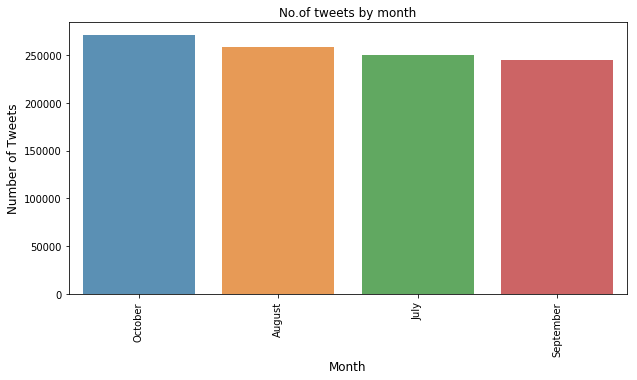

In [36]:
## Visulalising no.of twets tweeted in a month
train_json['tweet_month'] = train_json['timestamp'].dt.month_name()

count_  = train_json['tweet_month'].value_counts()
count_ = count_[:10,]
plt.figure(figsize=(10,5))
sns.barplot(count_.index, count_.values, alpha=0.8)
plt.title('No.of tweets by month')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

## Observations
* The composite index of NASDAQ for the months of July to Septmeber is between 8150-8350USD. There is not much price movement. Hence,it possible that the tweet count is similar

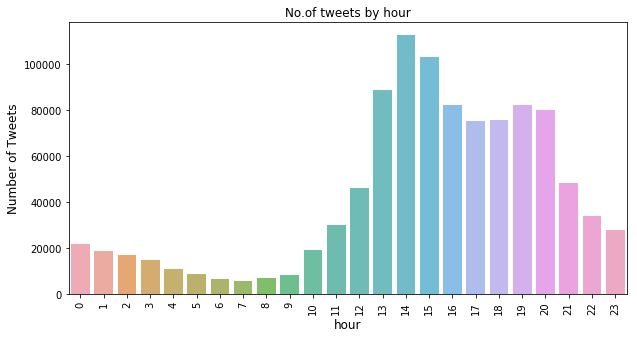

In [37]:
## Visulalising no.of twets tweeted in an hour
train_json['tweet_hour'] = train_json['timestamp'].dt.hour

count_  = train_json['tweet_hour'].value_counts()
count_ = count_[:24,]
plt.figure(figsize=(10,5))
sns.barplot(count_.index, count_.values, alpha=0.8)

plt.title('No.of tweets by hour')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('hour', fontsize=12)
plt.show()

## Observations
* New York Stock exchange and NASDAQ open time is 9.30am to 4pm
* There is a time difference of 3hrs between east and west coast, hence, instead of peak at 9.30am there is a peak around 11am-12pm

In [38]:
cnt_ = train_json['tweet_hour'].value_counts()
cnt_ = cnt_.sort_index() 
trace1 = go.Scatter(
                    x = cnt_.index,
                    y = cnt_.values,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)')
                    )

data = [trace1]
layout = dict(title = 'Number of tweets per hour',
              xaxis= dict(title= 'Tweets per hour',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

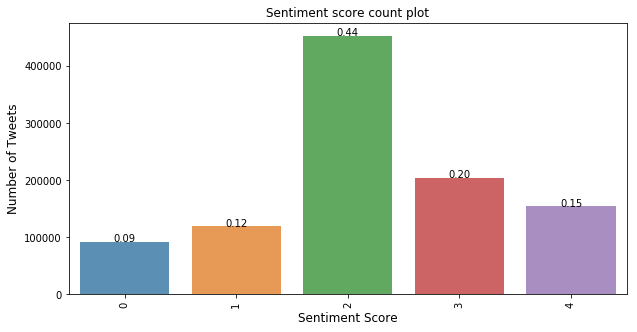

In [39]:
#Visualising the counts of sentiment scores

count_2  = train_json['sentiment_score'].value_counts()
plt.figure(figsize=(10,5))
ax_1= sns.barplot(count_2.index, count_2.values, alpha=0.8)

plt.title('Sentiment score count plot')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Sentiment Score', fontsize=12)

total = len(train_json)               
for p in ax_1.patches:
    height = p.get_height()
    ax_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show()


## Observations
* Most of the sentiment is nuetral. It could mean that the market is overall stable during the said period.
*  The composite index of NASDAQ for the months of July to Septmeber is between 8150-8350USD. There is not much price movement. Hence,it possible that the sentiment is Neutral

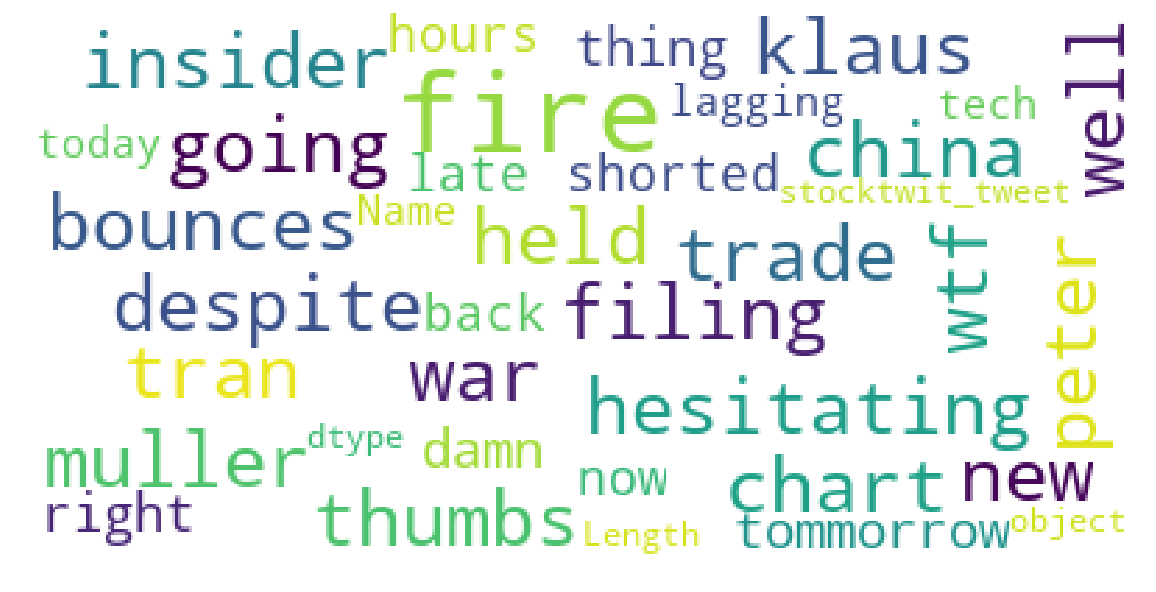

In [40]:
# Mapping Word Cloud for all words
from wordcloud import WordCloud, STOPWORDS
wordcloud_all = WordCloud(
                          background_color='white',
                          stopwords=set(STOPWORDS),
                          max_words=250,
                          max_font_size=40, 
                          random_state=1705
                         ).generate(str(train_json['stocktwit_tweet']))
def cloud_plot(wordcloud):
    fig = plt.figure(1, figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
cloud_plot(wordcloud_all)

## Observations
* "China","Trade" and "War" words could refer to the ongoing Trade war between China and USA and their significant impact on the stock market
* "WTF" could refer to the sudden changes in the market due to unexpected news, such as a news similar to the above trade war
* "Muller" could refer to the Special Counsel Robert Muller overseeing the investigation of Russian Meddling in the USA elections. This shows how ongoing investigations too have impact on the stock prices
* "Fire" could refer to California Wild fires of 2019 which started in the Month of June and went on till November. The given data for months og July to Spetmeber so, it isn't suprising that "Fire" is frequently used word
* "Klaus" refers to MULLER KLAUS PETER 
* "Filing" "Insider" they occur in conjunction, they could refer to any specualtion on the insider information that could predict the stock movement

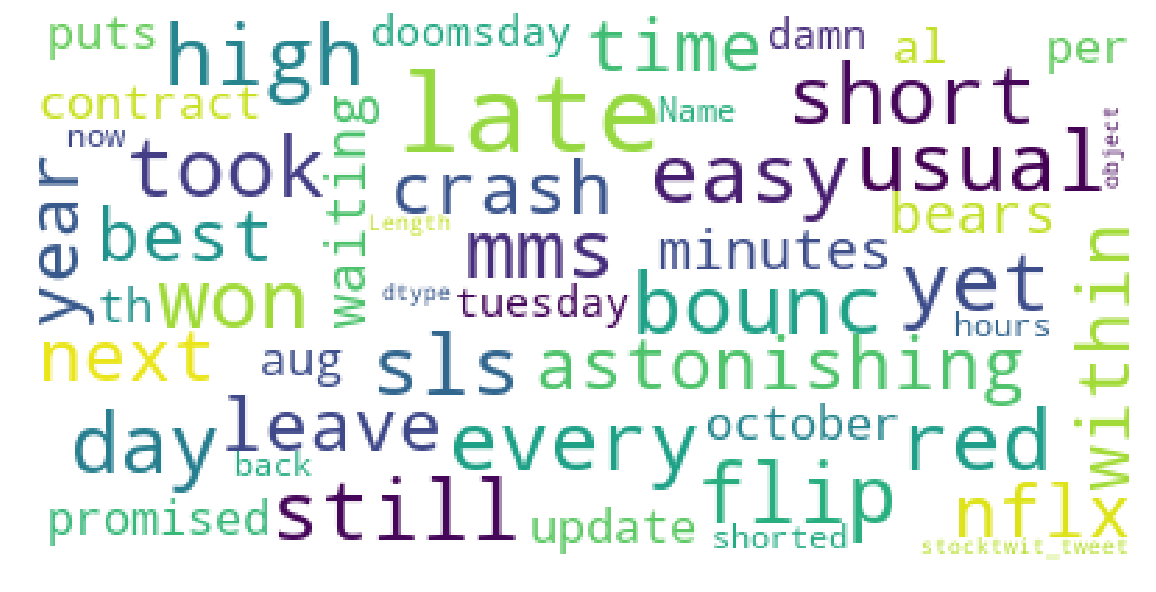

In [41]:
# Mapping Word Cloud for Sentiment_Score=0
from wordcloud import WordCloud, STOPWORDS
wordcloud_all = WordCloud(
                          background_color='white',
                          stopwords=set(STOPWORDS),
                          max_words=250,
                          max_font_size=40, 
                          random_state=1705
                         ).generate(str(train_json['stocktwit_tweet'][train_json['sentiment_score']==0]))
def cloud_plot(wordcloud):
    fig = plt.figure(1, figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
cloud_plot(wordcloud_all)

## Observations
As expected, most of the frquent words for negative sentiment are negative. Below are the few key words
* "Doomsaday", "damn", "red","crash", "astonishing","flip", "BEARS","Waiting" etc.

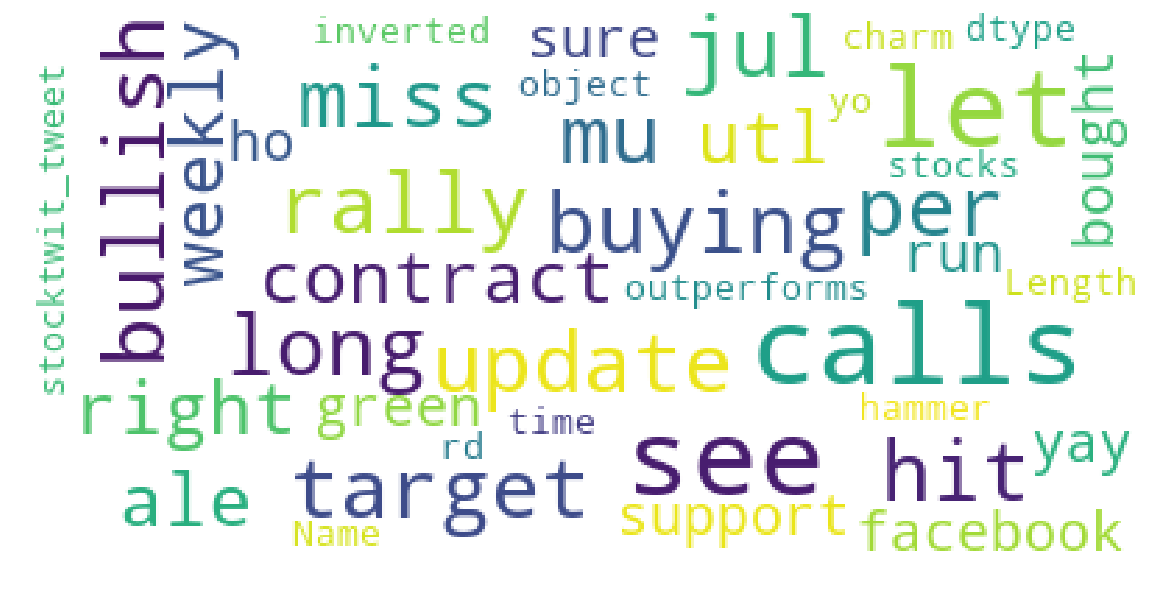

In [42]:
# Mapping Word Cloud for Sentiment_Score=0
from wordcloud import WordCloud, STOPWORDS
wordcloud_all = WordCloud(
                          background_color='white',
                          stopwords=set(STOPWORDS),
                          max_words=250,
                          max_font_size=40, 
                          random_state=1705
                         ).generate(str(train_json['stocktwit_tweet'][train_json['sentiment_score']==4]))
def cloud_plot(wordcloud):
    fig = plt.figure(1, figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
cloud_plot(wordcloud_all)

## Observations
As expected, most of the frquent words for sentiment score 4 are positive. Below are the few key words
* Bullish,Long,Calls,hit,bought,green etc

# Analyising the Factors.csv file

In [43]:
train_factors = pd.read_csv(url2)

In [44]:
train_factors.head(2)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3


In [45]:
print(np.size(train_factors['ticker'].unique()))


1304


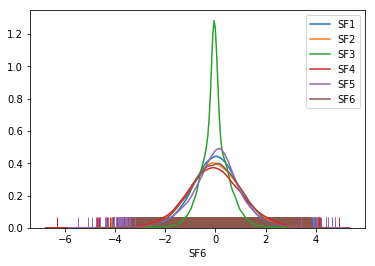

In [46]:
# Distribution plots for factors
sns.distplot(train_factors['SF1'], hist=False, rug=True,label="SF1")
sns.distplot(train_factors['SF2'], hist=False, rug=True,label="SF2")
sns.distplot(train_factors['SF3'], hist=False, rug=True,label="SF3")
sns.distplot(train_factors['SF4'], hist=False, rug=True,label="SF4")
sns.distplot(train_factors['SF5'], hist=False, rug=True,label="SF5")
sns.distplot(train_factors['SF6'], hist=False, rug=True,label="SF6")


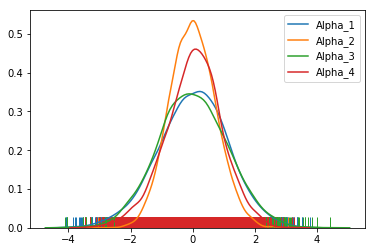

In [47]:
# Visualising SF1 distribution with respect to different values of "alpha"
Alpha_1 = train_factors.loc[train_factors['alpha'] == 1]
Alpha_2= train_factors.loc[train_factors['alpha'] == 2]
Alpha_3 = train_factors.loc[train_factors['alpha'] == 3]
Alpha_4 = train_factors.loc[train_factors['alpha'] == 4]


sns.distplot(Alpha_1[['SF1']], hist=False, rug=True,label="Alpha_1")
sns.distplot(Alpha_2[['SF1']], hist=False, rug=True,label="Alpha_2")
sns.distplot(Alpha_3[['SF1']], hist=False, rug=True,label="Alpha_3")
sns.distplot(Alpha_4[['SF1']], hist=False, rug=True,label="Alpha_4")

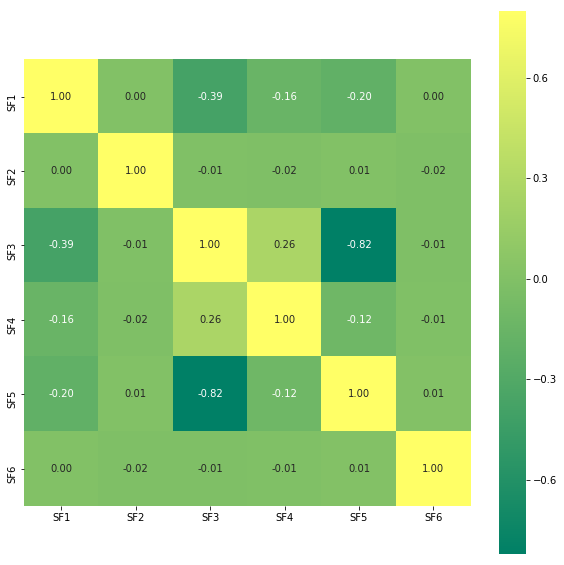

In [48]:
#Correlation plot for Factors
corrmat = train_factors[["SF1","SF2","SF3","SF4","SF5","SF6"]].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap = "summer");
plt.show()

## Observations
SF3 and SF5 are highly correlated. During the model builiding this high collinearity has to be handled

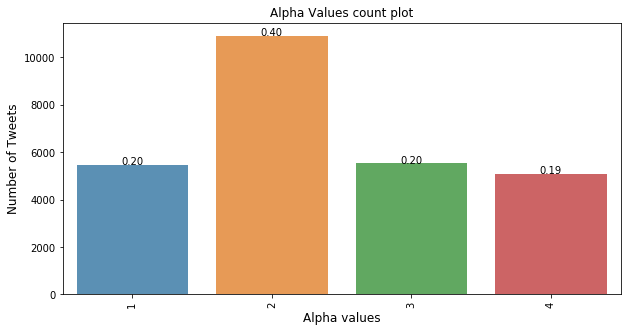

In [49]:
#Visualising the counts of Alpha values

count_3  = train_factors['alpha'].value_counts()
plt.figure(figsize=(10,5))
ax = sns.barplot(count_3.index, count_3.values, alpha=0.8)

plt.title('Alpha Values count plot')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Alpha values', fontsize=12)

total = len(train_factors)               
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 



In [50]:
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

## Will Adding sentiment score help with improving the prediciton accuracy??

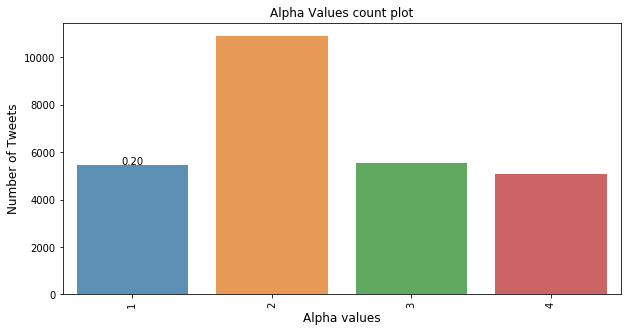

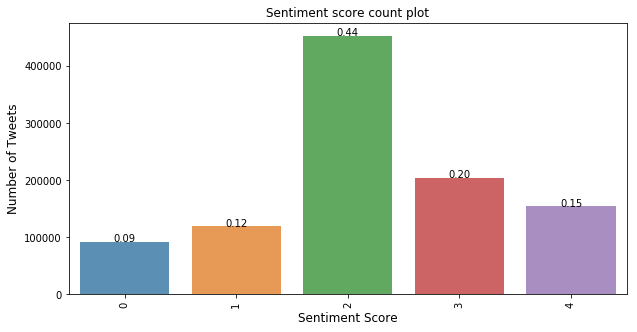

In [51]:
#Visualising the counts of Alpha values

count_3  = train_factors['alpha'].value_counts()
plt.figure(figsize=(10,5))
ax = sns.barplot(count_3.index, count_3.values, alpha=0.8)

plt.title('Alpha Values count plot')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Alpha values', fontsize=12)

total = len(train_factors)               
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
    plt.show()
    
#Visualising the counts of sentiment scores

count_2  = train_json['sentiment_score'].value_counts()
plt.figure(figsize=(10,5))
ax_1= sns.barplot(count_2.index, count_2.values, alpha=0.8)

plt.title('Sentiment score count plot')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Sentiment Score', fontsize=12)

total = len(train_json)               
for p in ax_1.patches:
    height = p.get_height()
    ax_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show()

    


### Conclusion: If we compare the distribution of no.of the tweets of different levels of Alpha values and sentiment score, they follow the same trend. Increasing, peaking around Neutral score and decreasing again. It can be inferred that they move together i.e correlated in some way. Hence, adding sentiment score might help in increasing prediciton accuracy